In [35]:
from collections import defaultdict
import pycolmap

In [36]:
# colmap_dir = "/private/home/miguelmartin/ego4d/ego4d_public/colmap_experiments/output/sfu_1a69642e-93d6-4faa-93df-72ee253bced5/OPENCV_FISHEYE_s1_r1_a1_fr0.250/"
# cache_dir = "/private/home/miguelmartin/ego4d/ego4d_public/colmap_experiments/cache/sfu_1a69642e-93d6-4faa-93df-72ee253bced5"

colmap_dir = "/private/home/miguelmartin/ego4d/ego4d_public/colmap_experiments/output/unc_T1/OPENCV_FISHEYE_s1_r1_a1_fr0.250/"
cache_dir = "/private/home/miguelmartin/ego4d/ego4d_public/colmap_experiments/cache/unc_T1"

In [37]:
!ls $cache_dir

aria01	cam01  cam02  cam03  cam04  dataset  mobile  timesync.csv


In [38]:
VRS_BIN = "/usr/local/bin/vrs"

In [39]:
import json
import os

from numpy.linalg import inv


from iopath.common.file_io import PathManager
from iopath.common.s3 import S3PathHandler
pathmgr = PathManager()
pathmgr.register_handler(S3PathHandler(profile="default"))

In [40]:
# metadata_path = "s3://ego4d-consortium-sharing/internal/egoexo_pilot/sfu/1a69642e-93d6-4faa-93df-72ee253bced5/metadata.json"
# metadata_path = "s3://ego4d-consortium-sharing/internal/egoexo_pilot/unc/T1/metadata.json"
# metadata_json = json.load(pathmgr.open(metadata_path))

In [41]:
# aria_metadata = metadata_json["videos"][0]["mps_output_dir"]

# # traj_dir = os.path.join(aria_metadata, "trajectory/")
# # traj_file = os.path.join(traj_dir, "closed_loop_trajectory.csv")
# # calib_file = os.path.join(traj_dir, "online_calibration.jsonl")

# traj_dir = "s3://ego4d-consortium-sharing/internal/temple3_egoexo/unc_t1/"
# gopro_calibs = os.path.join(traj_dir, "gopro_calibs.csv")
# traj_file0 = os.path.join(traj_dir, "multi_closed_loop_trajectory_framerate_0.csv")  # UNC T1
# traj_file1 = os.path.join(traj_dir, "multi_closed_loop_trajectory_framerate_1.csv")  # UNC T2
# traj_file1 = os.path.join(traj_dir, "multi_closed_loop_trajectory_framerate_2.csv")  # UNC T3
# multi_global_pts = os.path.join(traj_dir, "multi_global_points_0.csv")

In [42]:
# import pandas as pd

In [43]:
# gopro_calib_df = pd.read_csv(pathmgr.open(gopro_calibs))

In [44]:
# gopro_calib_df

In [45]:
# traj_df["tracking_timestamp_us"]

In [46]:
# traj_df.iloc[0]

In [47]:

# metadata_json = json.load(pathmgr.open(metadata_path))
# timesync_df = pd.read_csv(pathmgr.open(metadata_json["timesync_csv_path"]))

# traj_file = "s3://ego4d-consortium-sharing/internal/temple3_egoexo/unc_t1/multi_closed_loop_trajectory_framerate_0.csv"
# gopro_calibs_file = "s3://ego4d-consortium-sharing/internal/temple3_egoexo/unc_t1/gopro_calibs.csv"


In [48]:
# gopro_calibs_df = pd.read_csv(pathmgr.open(gopro_calibs_file))
# gopro_calibs_df

# Pose Model

In [49]:
# from mmpose.apis import (inference_top_down_pose_model, init_pose_model, process_mmdet_results, vis_pose_result)

In [50]:
import numpy as np

In [51]:
import av
import torchaudio
from torchaudio.io import StreamReader
import torch
from typing import Optional

def get_video_meta(path):
    with av.open(path) as cont:
        n_frames = cont.streams[0].frames
        codec = cont.streams[0].codec.name
        tb = cont.streams[0].time_base

        all_pts = []
        for x in cont.demux(video=0):
            if x.pts is None:
                continue
            all_pts.append(x.pts)

            if len(all_pts) >= 2:
                assert all_pts[-1] > all_pts[-2]

        assert len(all_pts) == n_frames
        return {
            "all_pts": all_pts,
            "codec": codec,
            "tb": tb,
        }

def _yuv_to_rgb(img):
    img = img.to(torch.float)
    y = img[..., 0, :, :]
    u = img[..., 1, :, :]
    v = img[..., 2, :, :]

    y /= 255
    u = u / 255 - 0.5
    v = v / 255 - 0.5

    r = y + 1.14 * v
    g = y + -0.396 * u - 0.581 * v
    b = y + 2.029 * u

    rgb = torch.stack([r, g, b], -1)
    rgb = (rgb * 255).clamp(0, 255).to(torch.uint8)
    return rgb


class StridedReader:
    def __init__(self, path, stride, frame_window_size):
        self.path = path
        self.meta = get_video_meta(path)
        self.all_pts = self.meta["all_pts"]
        self.stride = stride
        self.frame_window_size = frame_window_size
        if self.stride == 0:
            self.stride = self.frame_window_size

    def __getitem__(self, idx: int) -> torch.Tensor:
        raise AssertionError("Not implemented")

    def __len__(self):
        return int(math.ceil((len(self.all_pts) - self.frame_window_size) / self.stride))


class TorchAudioStreamReader(StridedReader):
    def __init__(self,
        path: str,
        size: Optional[int],
        mean: Optional[torch.Tensor],
        frame_window_size: int,
        stride: int,
        gpu_idx: int,
    ):
        super().__init__(path, stride, frame_window_size)

        self.mean = mean
        self.size = size
        self.gpu_id = gpu_idx
        
        decoder_basename = self.meta["codec"]
        if self.gpu_id >= 0:
            print("gpu_idx=", self.gpu_id)
            decoder_opt = (
                {"resize": f"{size}x{size}"}
                if size is not None
                else {}
            )
            self.conf = {
                "decoder": f"{decoder_basename}_cuvid",
                "hw_accel": f"cuda:{self.gpu_id}",
                "decoder_option": decoder_opt,
                "stream_index": 0,
            }
            self.resize = None
        else:
            self.conf = {
                "decoder": decoder_basename,
                "stream_index": 0,
            }
            self.resize = Resize((size, size)) if size is not None else None

        self.cont = StreamReader(self.path)
        self.cont.add_video_stream(self.frame_window_size, **self.conf)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        frame_i = self.stride * idx
        frame_j = frame_i + self.frame_window_size
        assert frame_i >= 0 and frame_j < len(self.all_pts)

        frame_i_pts = self.all_pts[frame_i]
        self.cont.seek(float(frame_i_pts * self.meta["tb"]))
        fs = None
        for fs in self.cont.stream():
            break

        assert fs is not None
        assert len(fs) == 1
        print([x.shape for x in fs])
        ret = _yuv_to_rgb(fs[0])
#         ret = fs[0]
        assert ret.shape[0] == self.frame_window_size
        if self.resize is not None:
            ret = self.resize(ret)
        if self.mean is not None:
            ret -= self.mean
        return ret

In [52]:
aria_path = '/private/home/miguelmartin/ego4d/ego4d_public/colmap_experiments/cache/unc_T1/aria01'

937.859920237

In [525]:
# TODO generalize to all cameras present not just cam01, cam02, cam03, cam04
from typing import Dict, Any
# NOTE order matters on pyark vs pyvrs, pyvrs must come first
from pyvrs.reader import SyncVRSReader
import cv2
import pandas as pd

def _get_synced_timesync_df(timesync_df):
    # start idx
    cam01_idx = timesync_df.cam01_global_time.first_valid_index()
    cam02_idx = timesync_df.cam02_global_time.first_valid_index()
    cam03_idx = timesync_df.cam03_global_time.first_valid_index()
    cam04_idx = timesync_df.cam04_global_time.first_valid_index()
    aria_rgb_idx = timesync_df["aria01_214-1_global_time"].first_valid_index()
    aria_slam1_idx = timesync_df["aria01_1201-1_global_time"].first_valid_index()
    aria_slam2_idx = timesync_df["aria01_1201-2_global_time"].first_valid_index()
    print(cam01_idx, cam02_idx, cam03_idx, cam04_idx, aria_rgb_idx, aria_slam1_idx, aria_slam2_idx)
    first_idx = max(cam01_idx, cam02_idx, cam03_idx, cam04_idx, aria_rgb_idx, aria_slam1_idx, aria_slam2_idx)

    # end idx
    last_cam01_idx = timesync_df.cam01_global_time.last_valid_index()
    last_cam02_idx = timesync_df.cam02_global_time.last_valid_index()
    last_cam03_idx = timesync_df.cam03_global_time.last_valid_index()
    last_cam04_idx = timesync_df.cam04_global_time.last_valid_index()
    aria_rgb_last_idx = timesync_df["aria01_214-1_global_time"].last_valid_index()
    aria_slam1_last_idx = timesync_df["aria01_1201-1_global_time"].last_valid_index()
    aria_slam2_last_idx = timesync_df["aria01_1201-2_global_time"].last_valid_index()
    print(aria_rgb_last_idx, aria_slam1_last_idx, aria_slam2_last_idx, last_cam01_idx, last_cam02_idx, last_cam03_idx, last_cam04_idx)
    last_idx = min(aria_rgb_last_idx, aria_slam1_last_idx, aria_slam2_last_idx, last_cam01_idx, last_cam02_idx, last_cam03_idx, last_cam04_idx)

    return timesync_df.iloc[first_idx:last_idx+1]

# TODO useme but this conflicts with pyark...
def _get_accurate_timestamps(aria_path, stream_id):
    vrs_r = SyncVRSReader(aria_path, auto_read_configuration_records=True)
    rgb_stream = vrs_r.filtered_by_fields(stream_ids={stream_id}, record_types="data")
    
    return{
        idx: f.timestamp * 1e6
        for idx, f in enumerate(rgb_stream)
    }
    

class SyncedEgoExoCaptureDset:
    def __init__(
        self,
        aria_path: str,
        aria_frame_path: str,
        metadata_path: str,
        traj_file: str,
        # TODO rename gopro -> exo
        gopro_calibs_file: str,
        gopro_dsets: Dict[str, Any],
        # TODO: removeme
        gopro_timesync_name_to_calib_name: Dict[str, str]
    ):
        self.metadata_json = json.load(pathmgr.open(metadata_path))
        self.aria_path = aria_path
        self.aria_frame_path = aria_frame_path
        
        self.traj_file = traj_file
        self.traj_df = pd.read_csv(pathmgr.open(self.traj_file))
        
        self.gopro_calibs_file = gopro_calibs_file
        self.gopro_calibs_df = pd.read_csv(pathmgr.open(self.gopro_calibs_file))
        
        self.gopro_timesync_name_to_calib_name = gopro_timesync_name_to_calib_name
        self.gopro_dsets = gopro_dsets
        
        self.timesync_df = pd.read_csv(pathmgr.open(self.metadata_json["timesync_csv_path"]))
        self.synced_df = _get_synced_timesync_df(self.timesync_df)
#         self.aria_frame_to_timestamp = aria_frame_to_timestamp
        
        
        aria_rel_frames = [
        #     os.path.join(aria_frame_path, f)
            f
            for f in os.listdir(os.path.join(aria_frame_path, "214-1"))
            if f.endswith("jpg")
        ]
#         aria_abs_frames = [ for f in aria_rel_frames]

        aria_frame_to_t = {
            int(f.split("-")[2]): float(".".join(f.split("-")[-1].split(".")[0:2])) * 1e6
            for f in aria_rel_frames
        }
        aria_frame_to_path = {
            int(f.split("-")[2]): os.path.join(aria_frame_path, "214-1", f)
            for f in aria_rel_frames
        }
        self.aria_frame_to_timestamp = aria_frame_to_t
        self.aria_frame_to_path = aria_frame_to_path
        
#         self.aria_frame_to_timestamp = _get_accurate_timestamps(aria_path, "214-1") # TODO: add option for stream
#         self.aria_camera_model = _get_aria_camera(aria_path)
        import pyark.datatools as datatools  # TODO: ask aria team on not breaking pyvrs
        vrs_data_provider = datatools.dataprovider.AriaVrsDataProvider()
        vrs_data_provider.openFile(aria_path)
        vrs_data_provider.loadDeviceModel()
        
#         vrs_data_provider = datatools.dataprovider.AriaVrsDataProvider()
#         vrs_data_provider.openFile(aria_path)
        self.aria_stream_id = datatools.dataprovider.StreamId(214, 1)
        vrs_data_provider.setStreamPlayer(self.aria_stream_id)
        vrs_data_provider.readFirstConfigurationRecord(self.aria_stream_id)
        vrs_data_provider.loadDeviceModel()

        self.aria_camera_model = vrs_data_provider.getDeviceModel()
        self.aria_rgb_camera = self.aria_camera_model.getCameraCalib('camera-rgb')
        self.vrs_data_provider = vrs_data_provider
        


    def __getitem__(self, idx):
        # NOTE this seems to be off by 1
        frame_idx = int(self.synced_df["aria01_214-1_frame_number"].iloc[idx])
        aria_t = self.aria_frame_to_timestamp[frame_idx]
        aria_pose = self.traj_df.iloc[(self.traj_df.tracking_timestamp_us - aria_t).abs().argsort().iloc[0]].to_dict()
        
        
        aria_frame_path = self.aria_frame_to_path[frame_idx]
        print(frame_idx, aria_frame_path)
        aria_frame = cv2.imread(aria_frame_path)
        
        values = {}
        cameras = {}
        for k, dset in self.gopro_dsets.items():
            gopro_idx = int(self.synced_df.iloc[idx][f"{k}_frame_number"])
            v = dset[gopro_idx]
            values[k] = v
            
            # TODO: changeme if gopro calibs file is per aria timestamp
            cam = self.gopro_calibs_df[
                self.gopro_calibs_df.gopro_uid == self.gopro_timesync_name_to_calib_name[k]
            ].iloc[0].to_dict()
            cameras[k] = cam
        
        return {
            "aria_pose": aria_pose,
            "aria_frame": aria_frame,
            "values": values,
            "cameras": cameras,
            "aria_t": aria_t,
        }
    
    def __len__(self):
        return len(self.synced_df)
    

class FrameDset:
    def __init__(self, path, gpu_idx=0):
        self.reader = TorchAudioStreamReader(
            path,
            frame_window_size=1,
            stride=1,
            gpu_idx=gpu_idx,
            size=None,
            mean=None,
        )
    
    def __getitem__(self, idx):
        return self.reader[idx]
    
    def __len__(self):
        return len(self.reader)

In [526]:
# metadata_path = "s3://ego4d-consortium-sharing/internal/egoexo_pilot/sfu/1a69642e-93d6-4faa-93df-72ee253bced5/metadata.json"
metadata_path = "s3://ego4d-consortium-sharing/internal/egoexo_pilot/unc/T1/metadata.json"
aria_path = os.path.join(cache_dir, "aria01")
aria_frame_path = "/private/home/miguelmartin/ego4d/ego4d_public/notebooks/aria_unc_t1"
traj_file = "s3://ego4d-consortium-sharing/internal/temple3_egoexo/unc_t1/multi_closed_loop_trajectory_framerate_0.csv"
gopro_calibs_file = "s3://ego4d-consortium-sharing/internal/temple3_egoexo/unc_t1/gopro_calibs.csv"
points_file = "s3://ego4d-consortium-sharing/internal/temple3_egoexo/unc_t1/multi_global_points_0.csv"
# TODO: get Jing to fix this
gopro_timesync_name_to_calib_name = {
    "cam01": "/home/jingdong/data/egoexo/unc_t1/raw/gopro1_%09d.jpg",
    "cam02": "/home/jingdong/data/egoexo/unc_t1/raw/gopro2_%09d.jpg",
    "cam03": "/home/jingdong/data/egoexo/unc_t1/raw/gopro3_%09d.jpg",
    "cam04": "/home/jingdong/data/egoexo/unc_t1/raw/gopro4_%09d.jpg",
}

gopro_paths = {
    "cam01": os.path.join(cache_dir, "cam01"),
    "cam02": os.path.join(cache_dir, "cam02"),
    "cam03": os.path.join(cache_dir, "cam03"),
    "cam04": os.path.join(cache_dir, "cam04"),
}

In [528]:
dset = SyncedEgoExoCaptureDset(
    aria_path=aria_path,
    aria_frame_path=aria_frame_path,
    metadata_path=metadata_path,
    traj_file=traj_file,
    gopro_calibs_file=gopro_calibs_file,
    gopro_dsets={
        "cam01": FrameDset(gopro_paths["cam01"]),
        "cam02": FrameDset(gopro_paths["cam02"]),
        "cam03": FrameDset(gopro_paths["cam03"]),
        "cam04": FrameDset(gopro_paths["cam04"]),
    },
    gopro_timesync_name_to_calib_name=gopro_timesync_name_to_calib_name,
)

gpu_idx= 0
gpu_idx= 0
gpu_idx= 0
gpu_idx= 0


/tmp/ipykernel_3024336/997654668.py:1: DtypeWarning: Columns (17,23) have mixed types.Specify dtype option on import or set low_memory=False.
  dset = SyncedEgoExoCaptureDset(


2639 2839 3043 3217 0 0 0
15790 15790 15790 16037 16194 16387 16542
Eye stream player doesn't exist, cannot update camera calibration


In [530]:
dset.synced_df["aria01_214-1_capture_timestamp_ns"].iloc[7000] / 1e9

937.859920237

In [534]:
dset[7000]["aria_t"] / 1e6

10217 /private/home/miguelmartin/ego4d/ego4d_public/notebooks/aria_unc_t1/214-1/214-1-10217-937.827.jpg
[torch.Size([1, 3, 2160, 3840])]
[torch.Size([1, 3, 2160, 3840])]
[torch.Size([1, 3, 2160, 3840])]
[torch.Size([1, 3, 2160, 3840])]


937.827

In [493]:
# # https://github.com/colmap/colmap/blob/d6f528ab59fd653966e857f8d0c2203212563631/scripts/python/read_write_model.py#L453
def qvec2rotmat(qvec):
    return np.array([
      [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
       2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
       2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
      [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
       1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
       2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
      [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
       2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
       1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

In [524]:
x = dset[7000]
x["aria_t"] / 1e6

10217 /private/home/miguelmartin/ego4d/ego4d_public/notebooks/aria_unc_t1/214-1/214-1-10217-937.827.jpg
[torch.Size([1, 3, 2160, 3840])]
[torch.Size([1, 3, 2160, 3840])]
[torch.Size([1, 3, 2160, 3840])]
[torch.Size([1, 3, 2160, 3840])]


937.827

In [496]:
t_world = np.array([
    x["aria_pose"]["tx_world_device"],
    x["aria_pose"]["ty_world_device"],
    x["aria_pose"]["tz_world_device"]]
)D
# aR = qvec2rotmat([
R_world = qvec2rotmat([
    x["aria_pose"]["qw_world_device"],
    x["aria_pose"]["qx_world_device"],
    x["aria_pose"]["qy_world_device"],
    x["aria_pose"]["qz_world_device"],
])

T_world_gopro = np.zeros((4, 4)) # world -> gopro
T_world_gopro[0:3, 0:3] = R_world # gopro rot
T_world_gopro[0:3, 3] = t_world # world pos
T_world_gopro[3, 3] = 1.0

T_gopro_world = inv(T_world_gopro)
t_local = T_gopro_world[0:3, 3]
R_local = T_gopro_world[0:3, 0:3]

aria_camera = {
    "center": t_world,
    "t_world": t_local,
#     "R": R_local,
    "T_device_world": inv(T_world_gopro),
    "T_world_device": T_world_gopro,
}
aria_camera

SyntaxError: invalid syntax (1510854833.py, line 5)

In [497]:
def _create_exo_camera(exo_cam_desc):
    params = [
        exo_cam_desc[f"intrinsics_{i}"]
        for i in range(8)
    ]
    camera = pycolmap.Camera(
        model="OPENCV_FISHEYE",
        width=exo_cam_desc["image_width"],
        height=exo_cam_desc["image_height"],
        params=params,
    )

    return camera

gopro_cameras = {}
for name in ["cam01", "cam02", "cam03", "cam04"]:
    ps = x["cameras"][name]
    cam = _create_exo_camera(ps)
    print(ps)
    t_world = np.array([
        ps["tx_world_gopro"],
        ps["ty_world_gopro"],
        ps["tz_world_gopro"]
    ])
#     R = qvec2rotmat([
    R_world = qvec2rotmat([
        ps["qw_world_gopro"],
        ps["qx_world_gopro"],
        ps["qy_world_gopro"],
        ps["qz_world_gopro"],
    ])
    T_world_gopro = np.zeros((4, 4)) # world -> gopro
    T_world_gopro[0:3, 0:3] = R_world # gopro rot
    T_world_gopro[0:3, 3] = t_world # world pos
    T_world_gopro[3, 3] = 1.0
    T_gopro_world = inv(T_world_gopro)
    t_local = T_gopro_world[0:3, 3]
    R_local = T_gopro_world[0:3, 0:3]
#     print("to_gopro=", t_gopro)
#     print(T_world_gopro)
#     print(t_world, t_gopro)
    gopro_cameras[name] = {
        "camera": cam,
        "T_world_device": T_world_gopro,
        "T_device_world": inv(T_world_gopro),
        "center": t_world,
        "R_world": R_world,
        "t_local": t_local,
        "t_world": t_world,
    }
    print("==")
    print(name)
    print(T_gopro_world)
    print("--")
    print(T_world_gopro)
#     print(-np.dot(R_gopro, t_world), t_gopro)
    cam = gopro_cameras[name]
    print("Rc + T = 0")
    print("Center Eq=", np.matmul(gopro_cameras[name]["T_device_world"], np.array(gopro_cameras[name]["center"].tolist() + [1.0])))
    print("Center=", cam["center"])
    print("===")

{'gopro_uid': '/home/jingdong/data/egoexo/unc_t1/raw/gopro1_%09d.jpg', 'tx_world_gopro': -0.653423, 'ty_world_gopro': -7.659884, 'tz_world_gopro': -0.216753, 'qx_world_gopro': -0.664825167, 'qy_world_gopro': -0.195264903, 'qz_world_gopro': 0.221679837, 'qw_world_gopro': 0.686102882, 'image_width': 3840, 'image_height': 2160, 'intrinsics_0': 1920.12487793, 'intrinsics_1': 1914.620605469, 'intrinsics_2': 1920.0, 'intrinsics_3': 1080.0, 'intrinsics_4': 0.032639414, 'intrinsics_5': 0.066838823, 'intrinsics_6': -0.065338001, 'intrinsics_7': 0.022063816}
==
cam01
[[ 0.82545934  0.56382439 -0.02681304  4.85239176]
 [-0.04455631  0.01773109 -0.99884951 -0.10979962]
 [-0.56270029  0.82570434  0.03975823  5.96573588]
 [ 0.          0.          0.          1.        ]]
--
[[ 0.82545934 -0.04455631 -0.56270029 -0.653423  ]
 [ 0.56382439  0.01773109  0.82570434 -7.659884  ]
 [-0.02681304 -0.99884951  0.03975823 -0.216753  ]
 [ 0.          0.          0.          1.        ]]
Rc + T = 0
Center Eq= [

In [498]:
camera = gopro_cameras["cam01"]
np.matmul(camera["T_world_device"][0:3, 0:4], np.array(camera["t_world"].tolist() + [1.0]))
np.matmul(camera["T_device_world"][0:3, 0:4], np.array([0.0, 0.0, 0.0] + [1.0]))

array([ 4.85239176, -0.10979962,  5.96573588])

In [499]:
np.matmul(aria_camera["T_world_device"][0:3, 0:4], np.array(aria_camera["t_world"].tolist() + [1.0]))
np.matmul(aria_camera["T_device_world"][0:3, 0:4], np.array([0.0, 0.0, 0.0] + [1.0]))

array([-0.71326657,  3.62907805,  5.36861649])

In [501]:
def world_pt_to_image(pt, from_camera, to_camera):
    pass

def device_pt_to_image(pt, from_camera, to_camera):
    pass

# GoPro -> Aria

In [502]:
print(gopro_cameras["cam04"]["T_world_device"])

[[-0.3686456   0.06938633  0.92697679 -5.668687  ]
 [-0.92749246  0.03917839 -0.37178326 -2.916972  ]
 [-0.06211413 -0.99682024  0.04991236 -0.239269  ]
 [ 0.          0.          0.          1.        ]]


In [503]:
import pyark.datatools as datatools

def get_camera_models(aria_path):
    vrs_data_provider = datatools.dataprovider.AriaVrsDataProvider()
    vrs_data_provider.openFile(aria_path)

    aria_stream_id = datatools.dataprovider.StreamId(214, 1)
    vrs_data_provider.setStreamPlayer(aria_stream_id)
    vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

    aria_stream_id = datatools.dataprovider.StreamId(1201, 1)
    vrs_data_provider.setStreamPlayer(aria_stream_id)
    vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

    aria_stream_id = datatools.dataprovider.StreamId(1201, 2)
    vrs_data_provider.setStreamPlayer(aria_stream_id)
    vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

    vrs_data_provider.loadDeviceModel()

    aria_camera_model = vrs_data_provider.getDeviceModel()
    slam_left = aria_camera_model.getCameraCalib("camera-slam-left")
    slam_right = aria_camera_model.getCameraCalib("camera-slam-right")
    rgb_cam = aria_camera_model.getCameraCalib("camera-rgb")
    assert slam_left is not None
    assert slam_right is not None
    assert rgb_cam is not None
    
    return {
        "1201-1": slam_left,
        "1201-2": slam_left,
        "214-1": rgb_cam,
    }


In [504]:
# gopro_calib_df

In [505]:
from typing import Dict, Any, Union
from dataclasses import dataclass

import copy
import pycolmap


Vec2 = np.array
Vec3 = np.array
Mat44 = np.array
AriaCameraModel = Any

# https://github.com/colmap/colmap/blob/d6f528ab59fd653966e857f8d0c2203212563631/scripts/python/read_write_model.py#L453
def qvec2rotmat(qvec):
    return np.array([
      [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
       2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
       2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
      [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
       1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
       2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
      [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
       2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
       1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])


def _create_exo_camera(exo_cam_desc):
    params = [
        exo_cam_desc[f"intrinsics_{i}"]
        for i in range(8)
    ]
    camera = pycolmap.Camera(
        model="OPENCV_FISHEYE",
        width=exo_cam_desc["image_width"],
        height=exo_cam_desc["image_height"],
        params=params,
    )

    return camera

@dataclass
class Camera:
    name: str
    camera_type: str
    center: Vec3 # in world coords
    T_device_world: Mat44 # project world pt into device frame
    T_world_device: Mat44 # project device pt into world frame
    T_device_camera: Mat44 # project camera pt into device frame
    T_camera_device: Mat44 # project device pt into camera frame
    camera_model: Union[pycolmap.Camera, AriaCameraModel]
    device_row: dict # raw data constructed camera from


def create_camera(camera_data, camera_model):
    ret = copy.deepcopy(camera_data)
    if camera_data["camera_type"] == "aria":
        assert camera_model is not None
        ret["camera_model"] = camera_model
    else:
        ret["camera_model"] = _create_exo_camera(ret["device_row"])
    return Camera(**ret)


def create_camera_data(
    device_row: Dict[str, Any],
    name: str,
    camera_model: Optional[Any],
    device_row_key: str,
) -> Dict[str, Any]:
    if camera_model is None:
        assert "cam" in name
        T_device_camera = np.eye(4)
        T_camera_device = np.eye(4)
        camera_model = _create_exo_camera(device_row)
        camera_type = "colmap"
    else:
        R = camera_model.T_Device_Camera.rotationMatrix()
        t = camera_model.T_Device_Camera.translation()
        T_device_camera = np.zeros((4, 4))
        T_device_camera[0:3, 0:3] = R
        T_device_camera[0:3, 3] = t
        T_device_camera[3, 3] = 1.0
        T_camera_device = inv(T_device_camera)
        camera_type = "aria"
    
    t_world = np.array([
        device_row[f"tx_world_{device_row_key}"],
        device_row[f"ty_world_{device_row_key}"],
        device_row[f"tz_world_{device_row_key}"]
    ])
    R_world = qvec2rotmat([
        device_row[f"qw_world_{device_row_key}"],
        device_row[f"qx_world_{device_row_key}"],
        device_row[f"qy_world_{device_row_key}"],
        device_row[f"qz_world_{device_row_key}"],
    ])
    T_world_device = np.zeros((4, 4))
    T_world_device[0:3, 0:3] = R_world
    T_world_device[0:3, 3] = t_world
    T_world_device[3, 3] = 1.0
    T_device_world = inv(T_world_device)
    
    return {
        "name": name,
        "center": t_world,
        # T_A_B = B is transformed to A's reference frame
        "T_device_world": T_device_world,
        "T_world_device": T_world_device,
        "T_device_camera": T_device_camera,
        "T_camera_device": T_camera_device,
        "camera_type": camera_type,
        "device_row": device_row,
    }


def xdevice_to_ximage(pt_device: Vec3, cam: Camera):
    if cam.camera_type == "aria":
        ret = cam.camera_model.projectionModel.project(pt_device)
    elif cam.camera_type == "colmap":
        ret = cam.camera_model.world_to_image(pt_device[0:2] / pt_device[2])
    return ret

def ximage_to_xdevice(pt_img: Vec2, cam: Camera):
    if cam.camera_type == "aria":
        ret = cam.camera_model.projectionModel.unproject(pt_img)
    elif cam.camera_type == "colmap":
        ret = cam.camera_model.image_to_world(pt_img)
    return ret

def xworld_to_yimage(pt3d: Vec3, to_cam: Camera):
    assert pt3d.shape[0] == 3
    T_to_world = np.matmul(to_cam.T_camera_device, to_cam.T_device_world)
    pt_target = np.matmul(T_to_world, np.array(pt3d.tolist() + [1.0]))[0:3]
    return xdevice_to_ximage(pt_target, to_cam)

def xdevice_to_yimage(pt3d: Vec3, from_cam: Camera, to_cam: Camera):
    assert pt3d.shape[0] == 3
    print(to_cam.T_device_camera)
    T_world_camera = np.matmul(to_cam.T_world_device, to_cam.T_device_camera)
    T_camera_world = inv(T_world_camera)

    # device -> world -> camera
    T_view_target = np.matmul(T_camera_world, from_cam.T_world_device)
    pt_target = np.matmul(T_view_target, np.array(pt3d.tolist() + [1.0]))[0:3]
    return xdevice_to_ximage(pt_target, to_cam)

def ximage_to_yimage(pt_img: Vec2, from_cam: Camera, to_cam: Camera, z: float = 1.0):
    pt_dev = ximage_to_xdevice(pt_img, from_cam)
    pt_dev = np.array(pt_dev.tolist() + [z])
    return xdevice_to_yimage(pt_dev, from_cam, to_cam)

In [506]:
# camera_models2 = get_camera_models(aria_path)
# camera_models2

In [507]:
# camera_models['214-1'].T_Device_Camera

In [508]:
# R = camera_models['214-1'].T_Device_Camera.rotationMatrix()
# t = camera_models['214-1'].T_Device_Camera.translation()
# T_device_camera = np.zeros((4, 4))
# T_device_camera[0:3, 0:3] = R
# T_device_camera[0:3, 3] = t
# T_device_camera[3, 3] = 1.0
# T_camera_device = inv(T_device_camera)
# camera_type = "aria"
# T_device_camera

In [509]:
# cam_view = gopro_cameras["cam01"]
# cam_target = aria_camera

# # sanity checks
# pred_center = np.matmul(cam_view["T_world_device"], np.array([0, 0, 0, 1]))
# assert np.isclose(cam_view["center"], pred_center[0:3]).all()
# assert (np.isclose(cam_view["T_device_world"], inv(cam_view["T_world_device"])).all())
# assert (np.isclose(cam_target["T_device_world"], inv(cam_target["T_world_device"])).all())

# # work
# # T_view_target = np.matmul(cam_view["T_device_world"], cam_target["T_world_device"])
# T_world_aria_rgb = np.matmul(cam_target["T_world_device"], T_device_camera)
# T_aria_rgb_world = inv(T_world_aria_rgb)
# # T_view_target = np.matmul(cam_view["T_device_world"], T_world_aria_rgb)
# T_view_target = np.matmul(T_aria_rgb_world, cam_view["T_world_device"])
# # T_view_target = np.matmul(T_view_target, T_device_camera)
# pt_target = np.matmul(T_view_target, np.array([0, 0, 0, 1]))[0:3]

# # print("pt=", pt_target)

# pt_img = dset.aria_rgb_camera.projectionModel.project(pt_target)
# pt_img

# GoPro -> GoPro

In [510]:
# cam_target = gopro_cameras["cam04"]
# cam_view = gopro_cameras["cam01"]

cam_view = aria_camera
cam_target = gopro_cameras["cam01"]
# cam_view = aria_camera

# working
T_view_target = np.matmul(cam_target["T_device_world"], cam_view["T_world_device"])
pt_target = np.matmul(T_view_target, np.array([0, 0, 0, 1]))[0:3]

print("Expected:", pt_target)

# alternative
# T_view_target = np.matmul(cam_target["T_device_world"], cam_view["T_world_device"])
# T_view_target = cam_view["T_world_device"]
# T_view_target = np.matmul(T_view_target, cam_view["T_device_world"])
T_view_target = cam_target["T_device_world"]
print("T_view_target")
print(T_view_target)
c = cam_view["center"].tolist() + [1]
# c[2] = 0.0
pt_target = np.matmul(T_view_target, np.array(c))[0:3]
print("Got:", pt_target)

# print("pt=", pt)

# ??? this doesn't work
# print(c[0:2])
# pt_img = cam_target["camera"].world_to_image(c[0:2] / c[2])
pt_img = cam_target["camera"].world_to_image(pt_target[0:2] / pt_target[2])
# expected_pt_img = cam_to["camera"].world_to_image(np.array([0.39648838, 0.02413426]))
pt_img

Expected: [-1.54910142 -0.0362571   7.1971888 ]
T_view_target
[[ 0.82545934  0.56382439 -0.02681304  4.85239176]
 [-0.04455631  0.01773109 -0.99884951 -0.10979962]
 [-0.56270029  0.82570434  0.03975823  5.96573588]
 [ 0.          0.          0.          1.        ]]
Got: [-1.54910142 -0.0362571   7.1971888 ]


array([1512.2815541 , 1070.48460437])

In [512]:
data = create_camera_data(x["aria_pose"], "214-1", camera_models2["214-1"], "device")
cam_aria = create_camera(data, camera_models[data["name"]])
# data
data = create_camera_data(x["cameras"]["cam01"], "cam01", None, "gopro")
cam01 = create_camera(data, None)

In [513]:
gopro_cameras["cam01"]["T_device_world"]

array([[ 0.82545934,  0.56382439, -0.02681304,  4.85239176],
       [-0.04455631,  0.01773109, -0.99884951, -0.10979962],
       [-0.56270029,  0.82570434,  0.03975823,  5.96573588],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [514]:
T_device_camera

array([[ 0.99458645, -0.05320471,  0.08925832, -0.00412324],
       [ 0.0969617 ,  0.78406035, -0.61306426, -0.01192084],
       [-0.037366  ,  0.61840005,  0.78497462, -0.0047089 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [515]:
cam_aria.T_device_camera

array([[ 0.99458645, -0.05320471,  0.08925832, -0.00412324],
       [ 0.0969617 ,  0.78406035, -0.61306426, -0.01192084],
       [-0.037366  ,  0.61840005,  0.78497462, -0.0047089 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [516]:
# pt_img = ximage_to_yimage([375, 1400], cam01, cam_aria)
# ximage_to_yimage(np.array([1000, 1500]), cam01, cam_aria)

In [517]:
# pt_img = world_to_image(cam_aria.center, cam01)
# pt_img

In [518]:
# pt_img = world_to_image(cam01.center, cam_aria)
# pt_img

In [519]:
pt_img = xdevice_to_yimage(np.array([0, 0, 0]), cam_aria, cam01)
pt_img

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


array([2500.99671102, 1063.59588179])

[2500.99671102 1063.59588179]


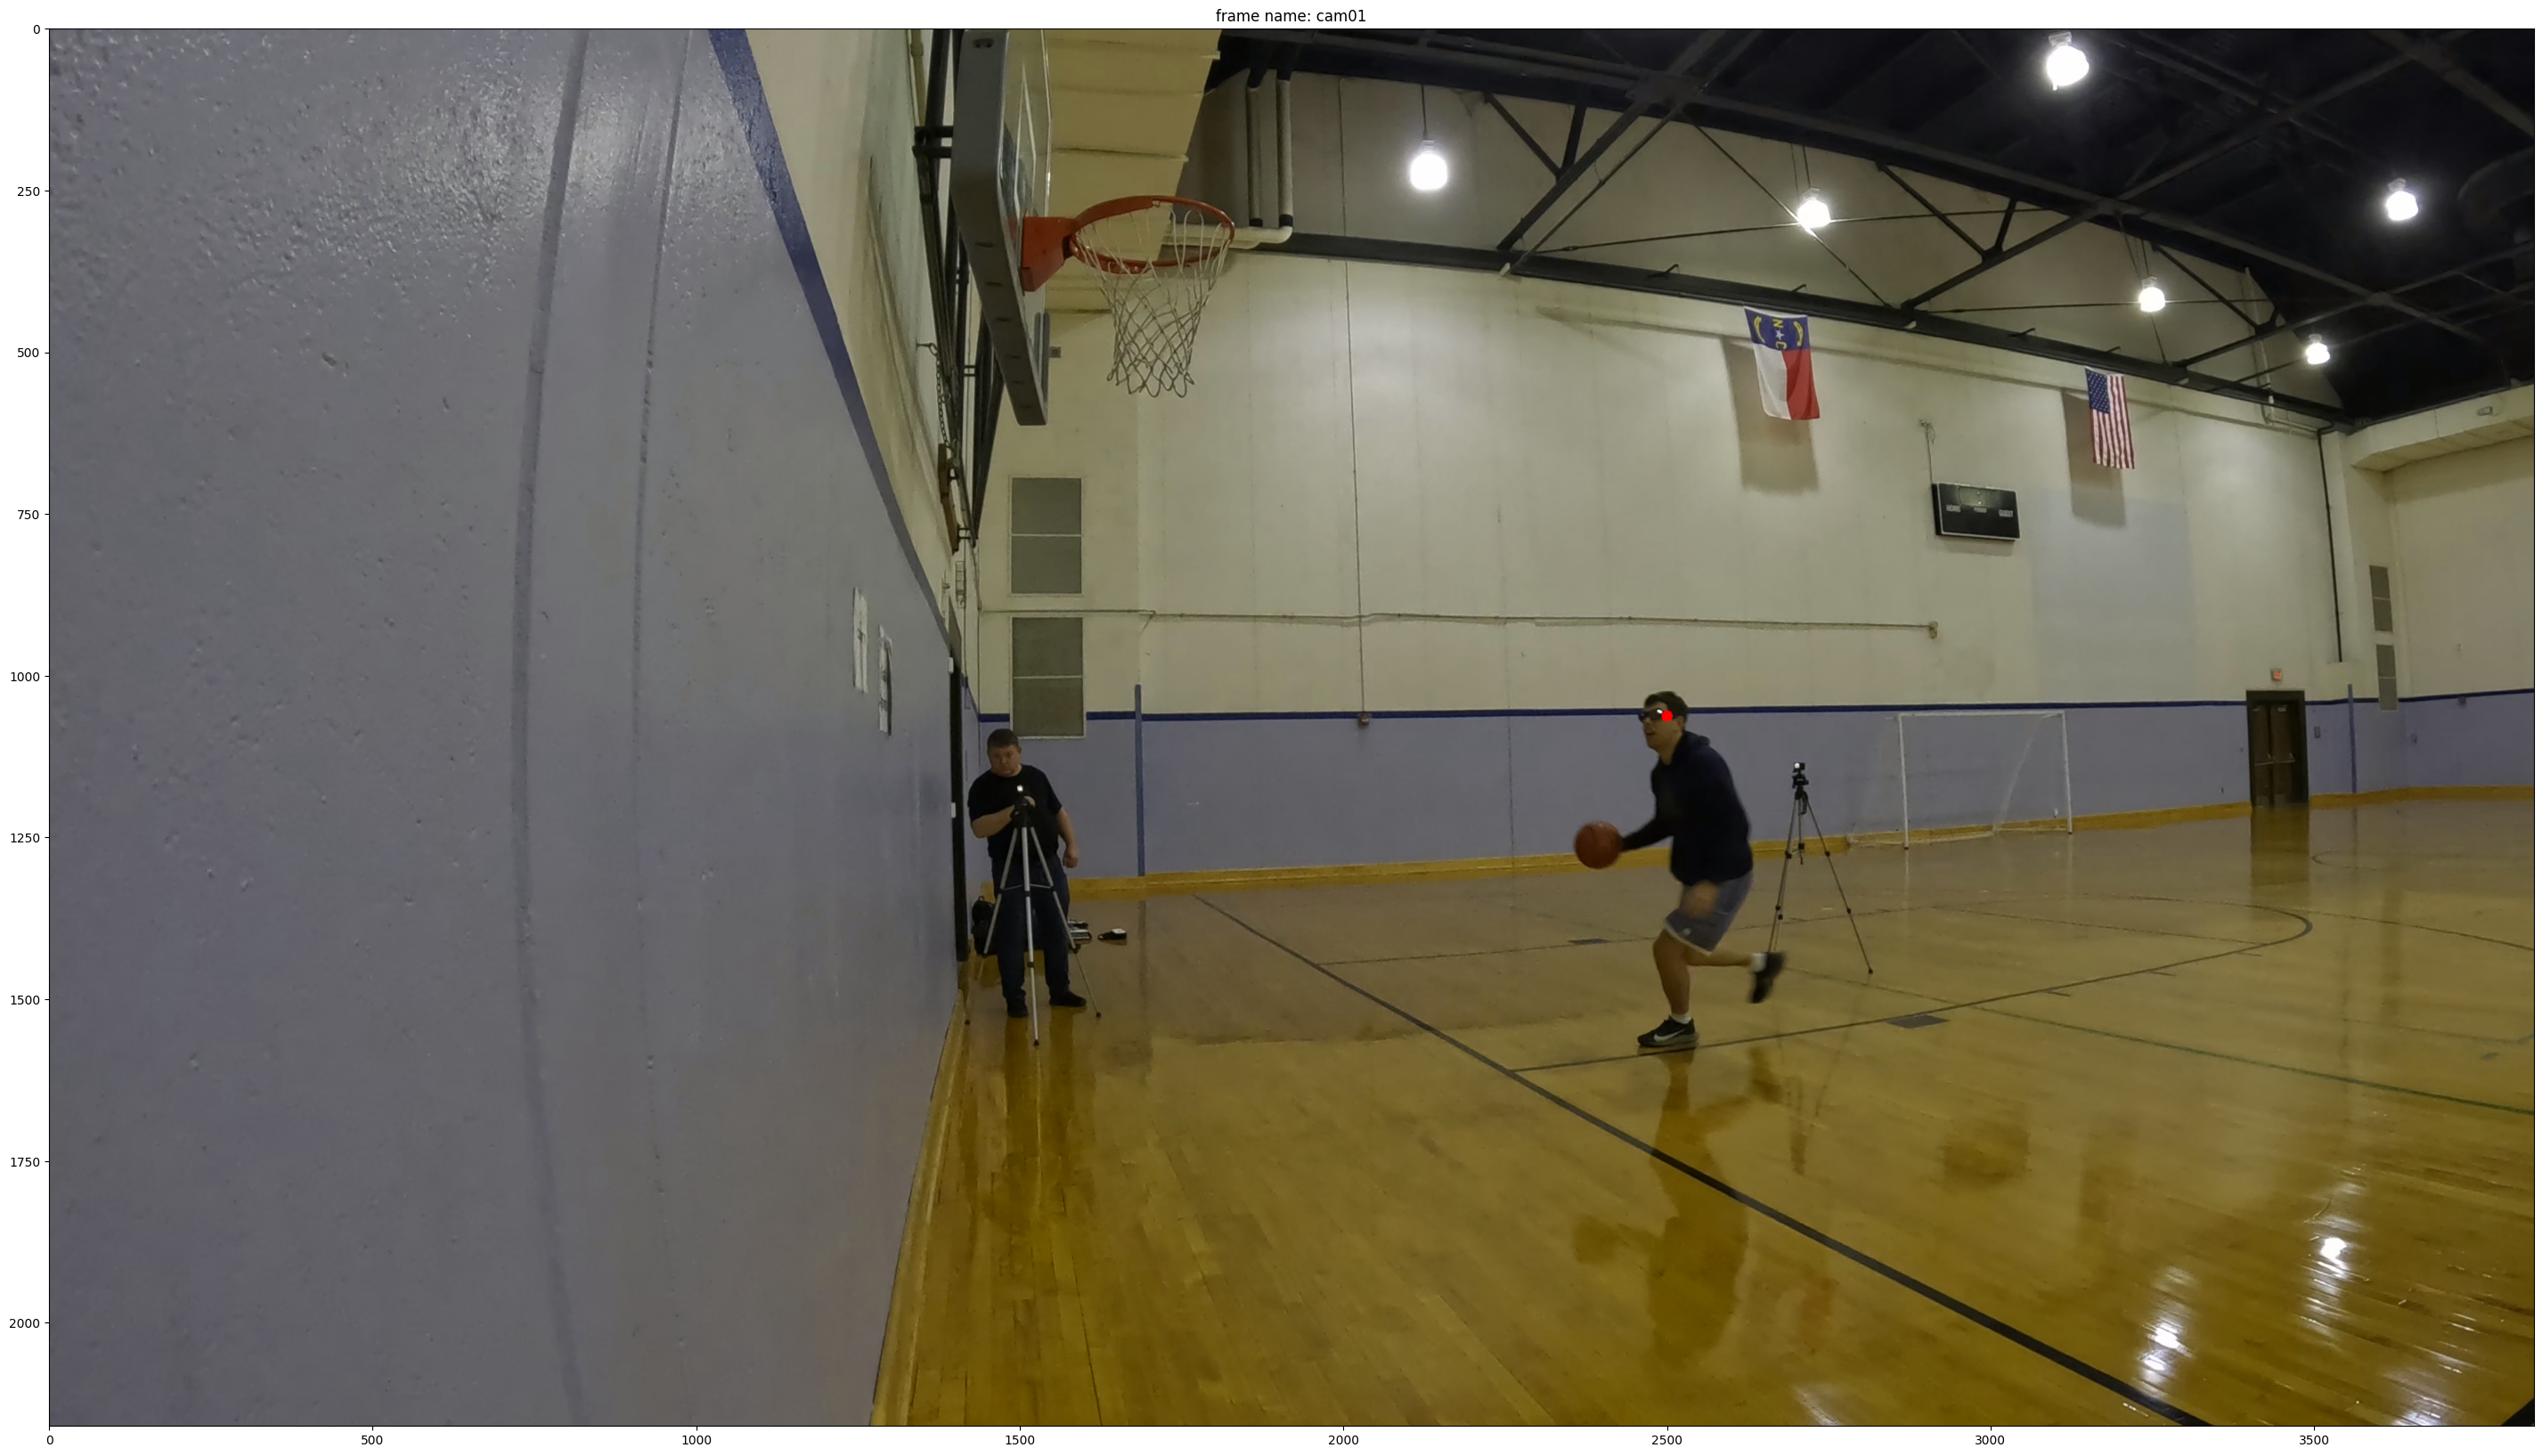

In [520]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams

cam_to_draw = "cam01"
# cam_to_draw = "cam03"
# cam_to_draw = "cam04"
# cam_to_draw = "aria01"
# cam_to_draw = "cam02"
thickness=10
color=(255, 0, 0)
radius=3

rcParams['figure.figsize'] = 36,128

N = 1
f, ax = plt.subplots(N, 1)

names = [cam_to_draw]
if cam_to_draw == "aria01":
    frames = [x["aria_frame"]]
else:  
    frames = [x["values"][cam_to_draw]]

for i in range(N):
    frame = frames[i].squeeze()
    if isinstance(frame, torch.Tensor):
        frame = frame.cpu().numpy()
    else:
        frame = frame.copy()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    print(pt_img)
#     frame = cv2.circle(frame, tuple(int(x) for x in pt_img), radius=radius, color=color, thickness=thickness)
    frame = cv2.circle(frame, tuple(int(x) for x in pt_img), radius=radius, color=color, thickness=thickness)
    
    
#     for k, pt_img in pts[cam_to_draw].items():
#         print(pt_img)
#         frame = cv2.circle(frame, tuple(int(x) for x in pt_img), radius=radius, color=color, thickness=thickness)
#     frame = frame.permute(1, 2, 0).cpu().numpy()
    ax.imshow(frame)
    ax.set_title(f"frame name: {names[i]}")

plt.show()

In [417]:
# pose_config = "/private/home/miguelmartin/ego4d/mmpose/configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/coco-wholebody/hrnet_w48_coco_wholebody_384x288_dark_plus.py"
# pose_checkpoint = "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth"

# # posetrack
# # pose_config = "configs/body/2d_kpt_sview_rgb_vid/posewarper/posetrack18/hrnet_w48_posetrack18_384x288_posewarper_stage2.py"
# # pose_checkpoint = "https://download.openmmlab.com/mmpose/top_down/posewarper/hrnet_w48_posetrack18_384x288_posewarper_stage2-4abf88db_20211130.pth"

# pose_model = init_pose_model(pose_config, pose_checkpoint, device='cuda:0'.lower())